In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [65]:
volume_data = pd.read_csv('Data/VolumeData.csv')
# Set 'stock_name' as the index
volume_data = volume_data.set_index('stock_name')

In [66]:
volume_data.head(5)

,day_1_interval_1_cum_volume,day_1_interval_2_cum_volume,day_1_interval_3_cum_volume,day_1_interval_4_cum_volume,day_1_interval_5_cum_volume,day_1_interval_6_cum_volume,day_1_interval_7_cum_volume,day_1_interval_8_cum_volume,day_1_interval_9_cum_volume,day_1_interval_10_cum_volume,...,day_65_interval_4_cum_volume,day_65_interval_5_cum_volume,day_65_interval_6_cum_volume,day_65_interval_7_cum_volume,day_65_interval_8_cum_volume,day_65_interval_9_cum_volume,day_65_interval_10_cum_volume,day_65_interval_11_cum_volume,day_65_interval_12_cum_volume,day_65_interval_13_cum_volume
stock_name,,,,,,,,,,,,,,,,,,,,,
SUNW,6357297.0,10019211.0,3041971.0,3085904.0,6282476.0,4353594.0,1679218.0,8505496.0,4096306.0,4446160.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
JAVA,6357297.0,10019211.0,3041971.0,3085904.0,6282476.0,4353594.0,1679218.0,8505496.0,4096306.0,4446160.0,...,6066557.0,2140346.0,5280698.0,11636293.0,5516903.0,2916502.0,4824326.0,3260273.0,8581782.0,14570556.0
ORCL,3232916.0,2479997.0,2619988.0,1980078.0,2542231.0,1619493.0,1459746.0,2265329.0,2081284.0,1689287.0,...,2967347.0,2223810.0,2756240.0,2273371.0,1797923.0,3400873.0,2586954.0,3747551.0,5046743.0,6473720.0
MSFT,4358789.0,3459064.0,2783535.0,1721782.0,2311063.0,2039914.0,1504351.0,2923864.0,1827550.0,2296702.0,...,5341118.0,4566510.0,3681682.0,3355531.0,3437090.0,3424036.0,4160368.0,4048302.0,5131117.0,7687305.0
AYE,104800.0,89400.0,73115.0,64200.0,64800.0,38300.0,35100.0,51600.0,38400.0,57100.0,...,32600.0,47800.0,41500.0,22900.0,17600.0,43700.0,37300.0,48700.0,53000.0,84800.0


In [67]:
# Function to create a new DataFrame containing features and target volume data.
def create_feature_target_df(volume_data):
    # Extract unique stock names, days, and intervals.
    stocks = volume_data.index.unique()
    days = 65
    intervals = 13

    # Generate column names for easier reference.
    columns = []
    for day in range(1, days+1):
        for interval in range(1, intervals+1):
            columns.append(f'day_{day}_interval_{interval}_cum_volume')

    # Set the DataFrame columns to the generated column names.
    volume_data.columns = columns

    # Initialize an empty list to store feature-target data.
    feature_target_data = []

    # Iterate over each stock.
    for stock in stocks:
        # Iterate over days.
        for day in range(1, days+1):
            # Iterate over each interval.
            for interval in range(1, intervals+1):
                # Define the current period's volume as the target.
                current_period = f'day_{day}_interval_{interval}_cum_volume'

                # Generate column names for the previous days based on the current day.
                previous_periods = [
                    f'day_{day-d}_interval_{interval}_cum_volume' if day-d > 0 else 'day_0_interval_0_cum_volume' for d in range(1, 10)
                ]

                # Generate column names for the two previous intervals before the current interval.
                previous_intervals = [
                    f'day_{day}_interval_{interval-4}_cum_volume' if interval > 4 else f'day_{day-1}_interval_{interval+12}_cum_volume',
                    f'day_{day}_interval_{interval-3}_cum_volume' if interval > 3 else f'day_{day-1}_interval_{interval+12}_cum_volume',
                    f'day_{day}_interval_{interval-2}_cum_volume' if interval > 2 else f'day_{day-1}_interval_{interval+11}_cum_volume',
                    f'day_{day}_interval_{interval-1}_cum_volume' if interval > 1 else f'day_{day-1}_interval_{interval+11-1}_cum_volume'
                ]
                #day_1_interval_10_cum_volume
                #print(previous_intervals)
                # Create a row dictionary with stock name and target volume.
                row = {
                    'stock_name': stock,
                    'target': volume_data.loc[stock, current_period]
                }

                # Add previous days' volumes as features to the row dictionary.
                for i, period in enumerate(previous_periods):
                    # If the previous day data is not available, fill with mean of the current day's volume for that interval.
                    if period not in volume_data.columns:
                        mean_volume = volume_data.loc[stock, current_period]
                    else:
                        mean_volume = volume_data.loc[stock, period]
                    row[f'feature_{i+1}'] = mean_volume

                # Add volumes of the two previous intervals before the current interval as additional features.
                for i, period in enumerate(previous_intervals):
                    # If the previous interval data is not available, fill with 0.
                    #print(period in volume_data.columns)
                    if period not in volume_data.columns:
                        previous_volume = 0
                    else:
                        previous_volume = volume_data.loc[stock, period]
                    row[f'feature_{i+10}'] = previous_volume

                # Append the row to the feature-target data list.
                feature_target_data.append(row)

    # Create a new DataFrame from the feature-target data.
    feature_target_df = pd.DataFrame(feature_target_data)
    return feature_target_df

# Create the feature-target DataFrame.
feature_target_df = create_feature_target_df(volume_data)

In [68]:
feature_target_df.head(5)

,stock_name,target,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13
0,SUNW,6357297.0,6357297.0,6357297.0,6357297.0,6357297.0,6357297.0,6357297.0,6357297.0,6357297.0,6357297.0,0.0,0.0,0.0,0.0
1,SUNW,10019211.0,10019211.0,10019211.0,10019211.0,10019211.0,10019211.0,10019211.0,10019211.0,10019211.0,10019211.0,0.0,0.0,0.0,6357297.0
2,SUNW,3041971.0,3041971.0,3041971.0,3041971.0,3041971.0,3041971.0,3041971.0,3041971.0,3041971.0,3041971.0,0.0,0.0,6357297.0,10019211.0
3,SUNW,3085904.0,3085904.0,3085904.0,3085904.0,3085904.0,3085904.0,3085904.0,3085904.0,3085904.0,3085904.0,0.0,6357297.0,10019211.0,3041971.0
4,SUNW,6282476.0,6282476.0,6282476.0,6282476.0,6282476.0,6282476.0,6282476.0,6282476.0,6282476.0,6282476.0,6357297.0,10019211.0,3041971.0,3085904.0


In [69]:
feature_target_df.shape[0] == 509*13*65 #sanity check

True

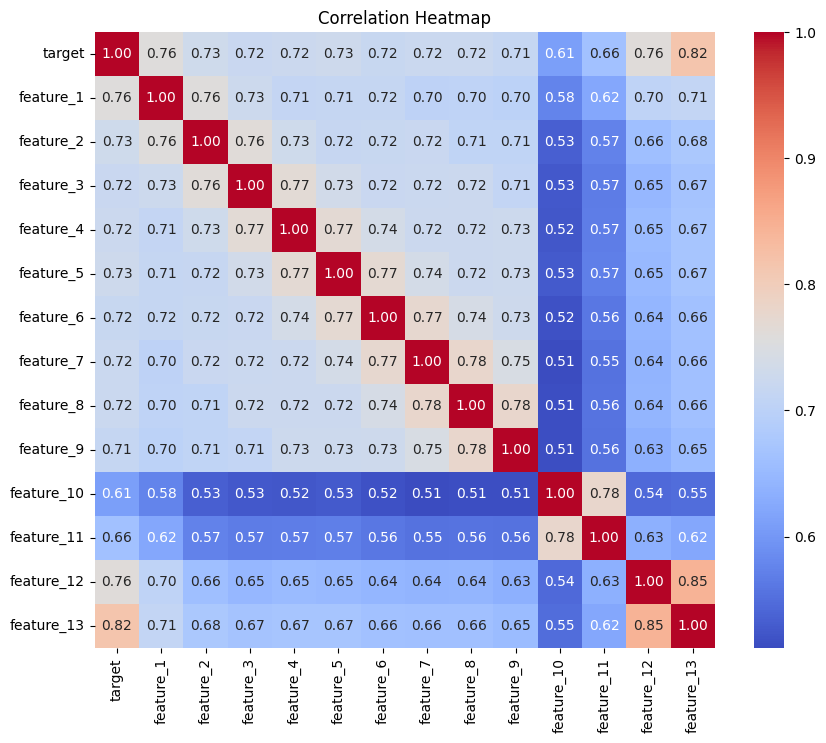

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = feature_target_df.drop("stock_name", axis = 1).corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [71]:
X = feature_target_df.drop(['stock_name','target'], axis=1)
y = feature_target_df['target']

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.linear_model import LinearRegression

'''# Initialize the Linear Regression model
linear_regressor = LinearRegression()

# Train the model
linear_regressor.fit(X_train, y_train)

# Predictions on the testing set
y_pred = linear_regressor.predict(X_test)'''

# Initialize the XGBoost regressor
xgb_regressor = xgb.XGBRegressor(objective ='reg:squarederror', random_state=42)

# Train the model
xgb_regressor.fit(X_train, y_train)

# Predictions on the testing set
y_pred = xgb_regressor.predict(X_test)

In [73]:
from sklearn.metrics import mean_absolute_error

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error: 131714133943.24316
Mean Absolute Error (MAE): 118922.66691681383
Root Mean Squared Error (RMSE): 362924.4190506381


In [74]:
y.mean()

391899.82313853595

In [75]:
X.mean()

feature_1     392792.642871
feature_2     392363.600574
feature_3     392012.359356
feature_4     393273.333837
feature_5     394510.792372
feature_6     395497.986220
feature_7     395745.991809
feature_8     396302.457653
feature_9     395747.821374
feature_10    304333.312919
feature_11    329849.147736
feature_12    390824.768550
feature_13    364090.118246
dtype: float64

In [76]:
X = feature_target_df.drop(['stock_name','target'], axis=1)
y = feature_target_df['target']

predictions = xgb_regressor.predict(X)

In [77]:
# Evaluate the model
mse = mean_squared_error(y, predictions)
print("Mean Squared Error:", mse)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y, predictions)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error: 79144883890.5905
Mean Absolute Error (MAE): 107208.6000777619


In [78]:
predictions = pd.DataFrame(predictions, columns=['volume'])
predictions["stock_name"] = feature_target_df["stock_name"]

In [79]:
predictions.head(5)

,volume,stock_name
0,4744635.5,SUNW
1,8974211.0,SUNW
2,5156768.5,SUNW
3,3041833.5,SUNW
4,7176360.5,SUNW


In [80]:
import pandas as pd
import numpy as np

# Assuming `predictions` DataFrame already exists

# Number of intervals in a day
intervals_per_day = 13
# Number of stocks
num_stocks = 509
# Number of days (assuming 66 for this example)
num_days = 65

# Total number of rows expected
total_rows = intervals_per_day * num_stocks * num_days

# Create the 'day' column
predictions['day'] = np.tile(np.repeat(np.arange(1, num_days + 1), intervals_per_day), num_stocks)

# Create the 'interval' column
predictions['interval'] = np.tile(np.arange(1, intervals_per_day + 1), num_days * num_stocks)

# Ensure the length of predictions matches the total_rows
assert len(predictions) == total_rows, "The DataFrame does not have the expected number of rows."

# Calculate cumulative volume and ratio
predictions['cumulative_volume'] = predictions.groupby(['stock_name', 'day'])['volume'].cumsum()
total_expected_volume = predictions.groupby(['stock_name', 'day'])['volume'].transform('sum')
predictions['cumulative_ratio'] = predictions['cumulative_volume'] / total_expected_volume

# Display the resulting DataFrame
predictions.head(10)

,volume,stock_name,day,interval,cumulative_volume,cumulative_ratio
0,4744635.5,SUNW,1,1,4744635.5,0.073333
1,8974211.0,SUNW,1,2,13718846.0,0.212040
2,5156768.5,SUNW,1,3,18875616.0,0.291743
3,3041833.5,SUNW,1,4,21917448.0,0.338758
4,7176360.5,SUNW,1,5,29093808.0,0.449676
5,4759750.0,SUNW,1,6,33853560.0,0.523243
6,2192316.0,SUNW,1,7,36045876.0,0.557128
7,5169847.0,SUNW,1,8,41215720.0,0.637033
8,4190918.0,SUNW,1,9,45406640.0,0.701809
9,4902238.0,SUNW,1,10,50308880.0,0.777578


In [81]:
#export the predictions
predictions.to_csv('Data/VolumePredictions.csv')